# Basic image anaylsis tutorial

This notebook documents basic (astronomical) image analysis with python.

In [1]:
# import the modules we need

import numpy as np
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Define where the image files are and what filters we have available

In [2]:

# the directory containing the images relative to this workbook 
image_dir = '../test_data/'

# list of filters 
filters = ['f115w', 'f150w', 'f200w', 'f277w', 'f356w', 'f444w']


Open the first image. The data is stored in a multi-extension FITS file. Essentially, in this case, the file contains three different image arrays:

- SCI: the science map, essentially a 2D array of the flux 
- ERR: the error map, an estimate of the error on every pixel
- WHT: the weight map

In [26]:

# open the i2d image file
hdul = fits.open(f"{image_dir}/f200w_i2d.fits")

# get info - 
hdul.info()


Filename: ../test_data//f200w_i2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SCI           1 ImageHDU        39   (200, 200)   float32   
  2  ERR           1 ImageHDU        39   (200, 200)   float32   
  3  WHT           1 ImageHDU        39   (200, 200)   float32   


### Explore the science map

(200, 200)
XTENSION IMAGE
BITPIX -32
NAXIS 2
NAXIS1 200
NAXIS2 200
PCOUNT 0
GCOUNT 1
EXTNAME SCI
WCSAXES 2
CRPIX1 26279.5
CRPIX2 -923.5
PC1_1 -0.64678977951046
PC1_2 -0.76266832969569
PC2_1 -0.76266832969569
PC2_2 0.64678977951046
CDELT1 8.3333333333333e-06
CDELT2 8.3333333333333e-06
CUNIT1 deg
CUNIT2 deg
CTYPE1 RA---TAN
CTYPE2 DEC--TAN
CRVAL1 214.825
CRVAL2 52.825
LONPOLE 180.0
LATPOLE 52.825
MJDREF 0.0
DATE-BEG 2022-06-21T18:09:46.649
MJD-BEG 59751.756789922
DATE-AVG 2022-06-21T19:19:05.420
MJD-AVG 59751.804923837
DATE-END 2022-06-21T20:27:34.055
MJD-END 59751.852477488
XPOSURE 49475.04
TELAPSE 49475.04
OBSGEO-X 362899179.14001
OBSGEO-Y -1339357702.7182
OBSGEO-Z -1035769565.0583
RADESYS ICRS
VELOSYS 14501.05


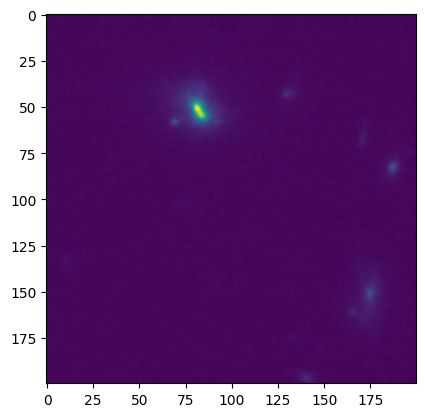

In [27]:

# grab the extension holding the science image
hdu = hdul['SCI']

# print the shape of the science image
print(hdu.data.shape)

# print the header keywords
for key, value in hdu.header.items():
    print(key, value)

# plot the data
plt.imshow(hdu.data)
plt.show()


In [28]:
sci = hdul['SCI'].data
err = hdul['ERR'].data

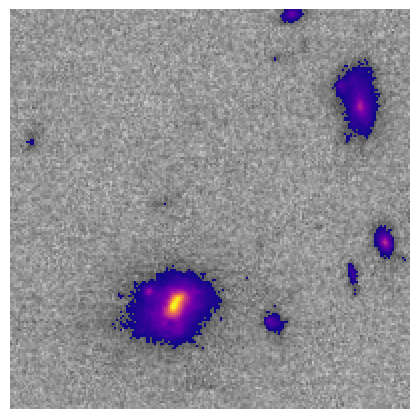

In [29]:


fig, ax = plt.subplots(1, 1, figsize = (4,4))
plt.subplots_adjust(left=0, top=1, bottom=0, right=1, wspace=0.01, hspace=0.0)

sig = sci/err

threshold = 2.5

ax.imshow(sig, cmap = cm.Greys, vmin = -threshold*2, vmax = threshold*2, origin = 'lower')
ax.imshow(np.ma.masked_where(sig <= threshold, sig), cmap = 'plasma', vmin = threshold, vmax = 50, origin = 'lower')
ax.set_axis_off()

plt.show()


see https://photutils.readthedocs.io/en/stable/segmentation.html 

In [30]:
from photutils.segmentation import detect_sources

segment_map = detect_sources(sig, 2.5, npixels=5)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (200, 200)
nlabels: 9
labels: [1 2 3 4 5 6 7 8 9]


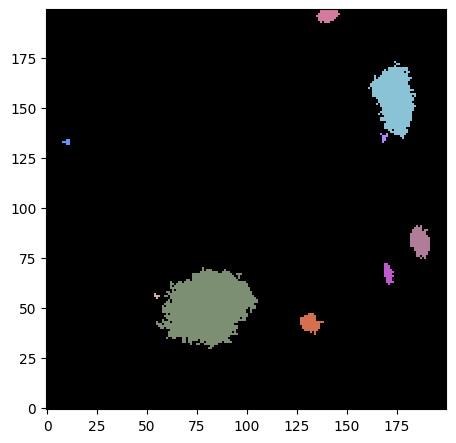

In [31]:

fig, ax = plt.subplots(1, 1, figsize = (4,4))
plt.subplots_adjust(left=0, top=1, bottom=0, right=1, wspace=0.01, hspace=0.0)
ax.imshow(segment_map, origin='lower', cmap=segment_map.cmap, interpolation='nearest')
plt.show()

### Make an RGB image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4190893].


-0.025060812 1.4190893
-0.03233687 1.17733
-0.025240425 0.80572975


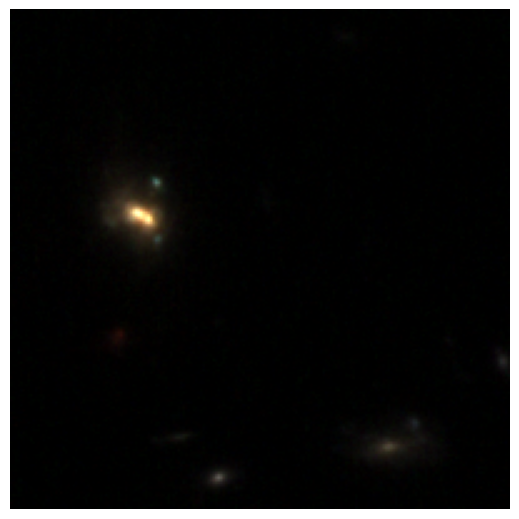

In [34]:
imsize = 5
fig, ax = plt.subplots(1, 1, figsize = (imsize,imsize))
plt.subplots_adjust(left=0, top=1, bottom=0, right=1, wspace=0.0, hspace=0.0)


rgb = []

scaling = {
    'r':1.0,
    'g':1.0,
    'b':1.0,
}

for label, filter in zip(['r', 'g', 'b'],['f200w','f150w','f115w']):

    hdul = fits.open(f"{image_dir}/{filter}_i2d.fits")

    print(np.min(hdul['SCI'].data), np.max(hdul['SCI'].data))

    im = scaling[label] * hdul['SCI'].data

    # exclude negative pixels
    im[im<0.0] = 0.0

    # im[im>0.5] = 0.5

    rgb.append(im)


ax.imshow(np.array(rgb).T)
ax.set_axis_off()
# ax.imshow(np.array([r.data,g.data,b.data]).T)

plt.show()